# Assignment 1

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2022/wiki/Assignment-1-and-2) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday February 28th, 2022 at 23:59. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Monday March 7th, 2022 at 23:59.

In [1]:
# Imports
import pandas as pd
import numpy as np
import folium
import seaborn as sns
from matplotlib import pyplot as plt
from folium.plugins import HeatMap, HeatMapWithTime
import math
from scipy.stats import ttest_ind
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

# Read crime data and sort chronologically
df = pd.read_csv('data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
D = pd.read_csv('data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
D['Date'] = pd.to_datetime(D.Date)
D['Time'] = pd.to_datetime(D.Time)
D = D.sort_values(by='Date')

# Focuscrimes and days
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])
DayOfWeeklist = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # Ordered categorical data

# Subset data for focus crimes
D = D[D['Category'].isin(focuscrimes)]
n, p = D.shape; print(f'rows = {n}, features = {p}')

rows = 1242811, features = 35


## Part 1: Visualizing patterns in the data

In this exercise, please generate the visualizations described below. Use the same date-ranges as in Week 2. For each set of plots, describe the plots (as you would in the figure text in a report or paper), and pick a few aspects that stand out to you and comment on those (we provided a couple of ideas during class but it's OK to add more).

We look only at the focus-crimes in the exercise below.

> *Exercise*: 
>
> * *Weekly patterns*. Basically, we'll forget about the yearly variation and just count up what happens during each weekday. [Here's what my version looks like](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/weekdays.png). Make your own version of the plot and comment your results.
> * *Hours of the week*. But by looking at just 24 hours, we may be missing some important trends that can be modulated by week-day, so let's also check out the 168 hours of the week. So let's see the number of each crime-type Monday night from midninght to 1am, Monday night from 1am-2am - all the way to Sunday night from 11pm to midnight. Visualize and comment your results.
> * *Spatial patterns*. Next, we want to generate a slightly more complicated graphic. I'm interested to know if there are certain crimes that happen much more in certain neighborhoods than what's typical:
>    - For each district plot the ratio `P(crime|district)/P(crime)` for the 14 focus crimes (follow and *show* the steps in Week 2 Ex. 2.2 for success).
>    - Comment on the top crimes in _Tenderloin_, _Mission_, and _Richmond_. Does this fit with the impression you get of these neighborhoods on Wikipedia?

In this exercise, we will dive deep into the Crime Data from San Fransisco Police Department in the period of 2003 to 2018. We will look into only the pre-defined "focus crimes", thus the dataset consists of 1.2 million rows each representing a specific crime comitted with 35 columns of features.

In [2]:
# Helper function and columns for the following plots
D['year'] = D['Date'].dt.year
D['month'] = D['Date'].dt.month
D['hour'] = D['Time'].dt.hour
D['DoWhour'] = D['DayOfWeek'] + D.hour.to_numpy(str)
DoWhourlist = [day + str(hour) for day in DayOfWeeklist for hour in range(0,24)] # Ordered categorical list for ordered bar plotting

def temporalcrimesplot(crime, temporal='month'): # temporal = 'month' or 'hour' or 'DayOfWeek' or 'DoWhour'
    if temporal == 'DayOfWeek' or temporal == 'DoWhour':
        index_to_sort_by = DayOfWeeklist if temporal == 'DayOfWeek' else DoWhourlist
        val_count = D[temporal][D.Category == crime].value_counts().reindex(index_to_sort_by).plot(kind='bar')
    else:
        val_count = D[temporal][D.Category == crime].value_counts().sort_index().plot(kind='bar')
    plt.tight_layout()
    plt.ylabel('Occurences')
    plt.title(f'{crime} per {temporal}')

#### 1.1) Weekly pattern:

Let's have a look into the weekly patterns of each crime

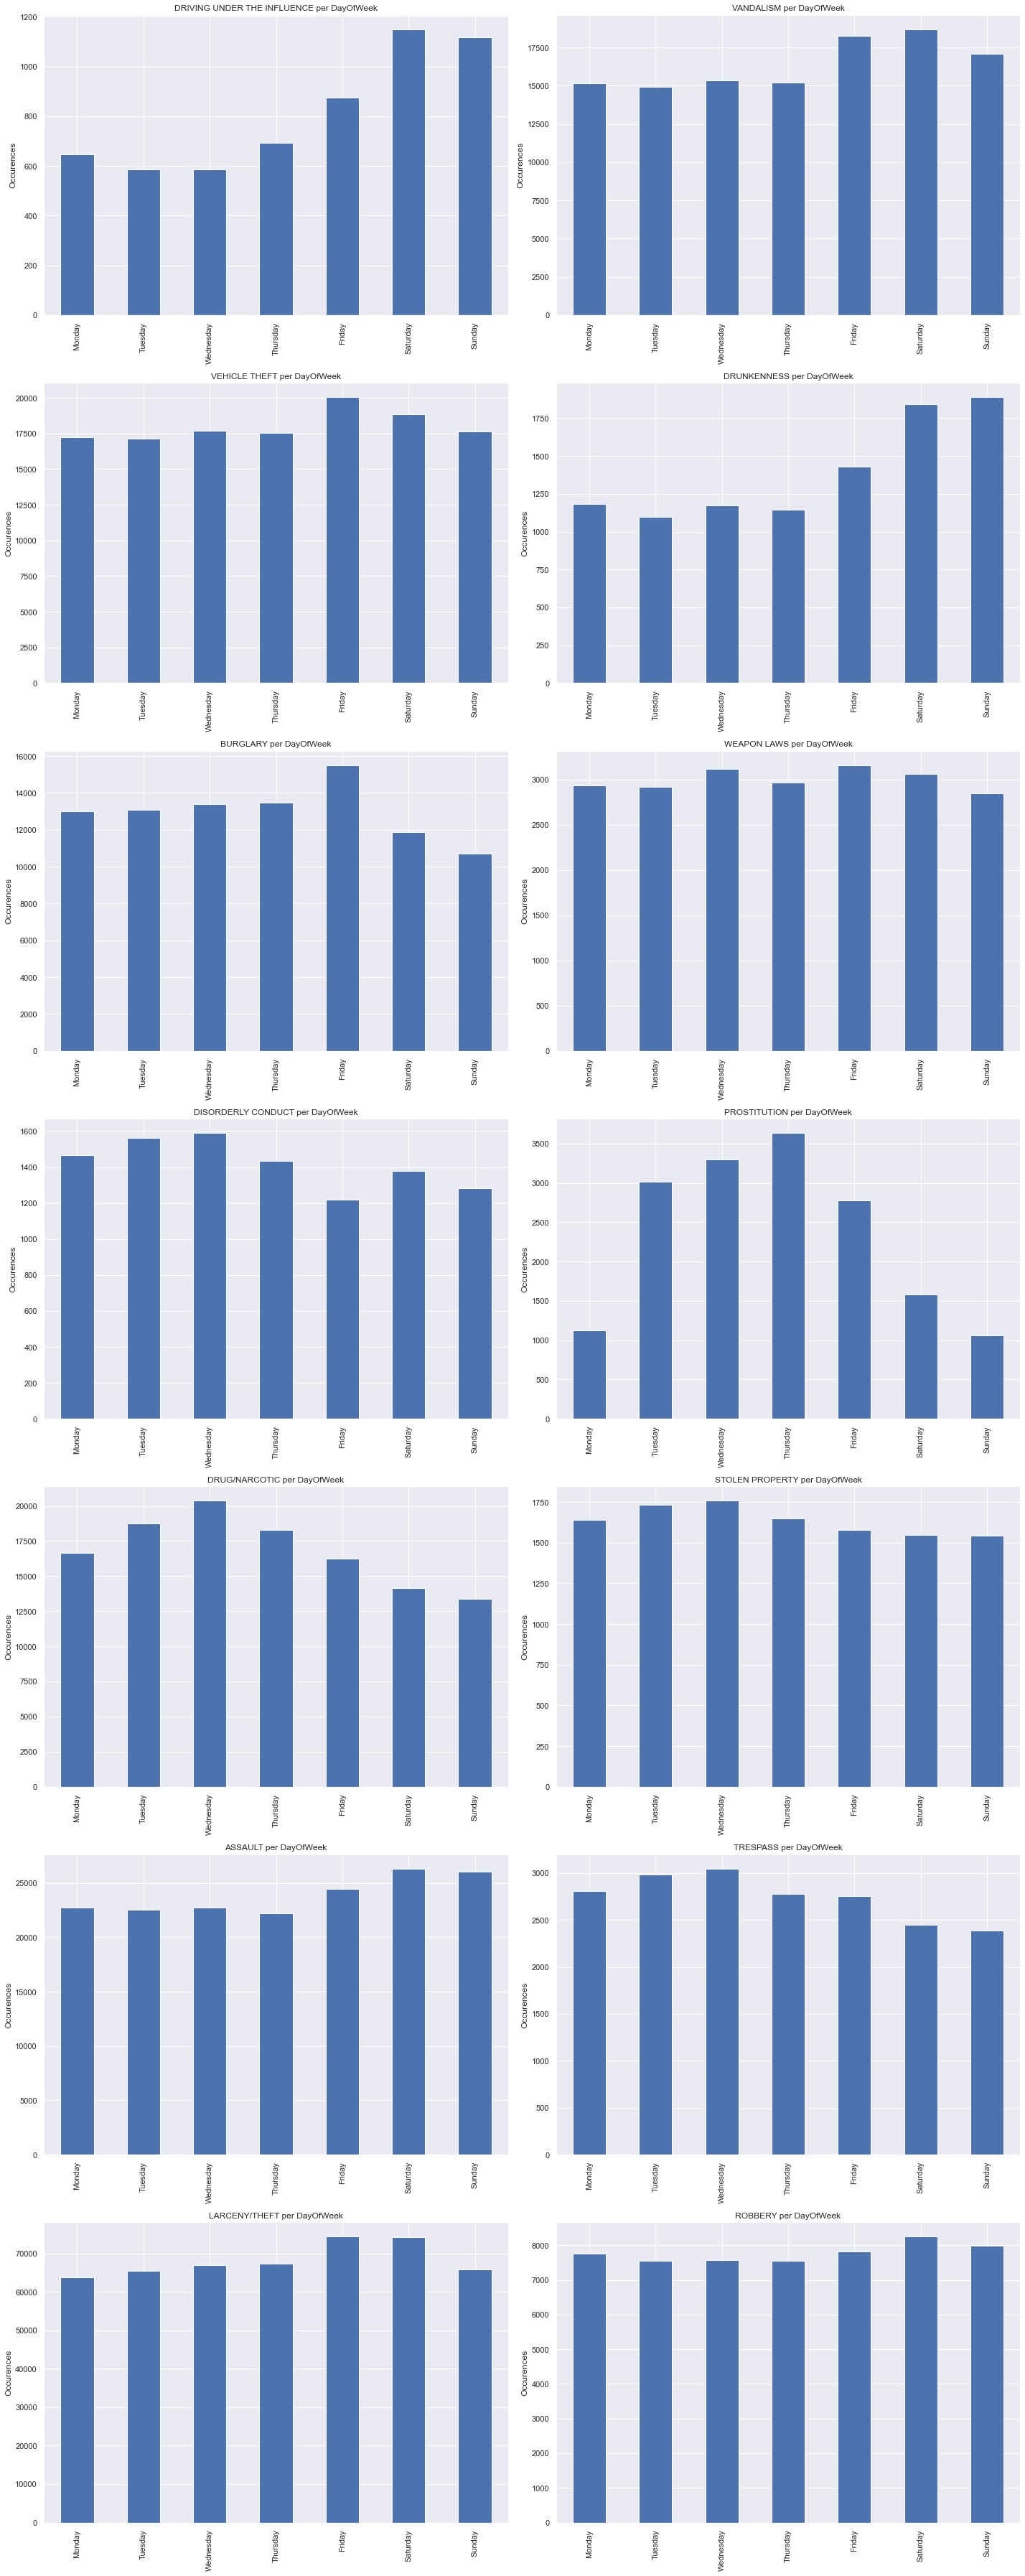

In [3]:
# Plot the weekly patterns of each focuscrime
temporal = 'DayOfWeek'

plt.figure(figsize=(20,50))
plt.title("Crime per weekday")
for i, crime in enumerate(focuscrimes):
    plt.subplot(int(len(focuscrimes)/2), 2,  i+1)
    temporalcrimesplot(crime, temporal=temporal)

Interestingly, we see clear weekly patterns in some of the crimes: Prostitution occurs (atleast the incidence reporting of such) much more in the middle of week, "Driving under influence" occurs much more in the weekend, wheras robbery is seemingly constant throughout the week.

#### 1.2) Hours of week:

Let's look into whether there is some specific hours each week where crime usually occurs.

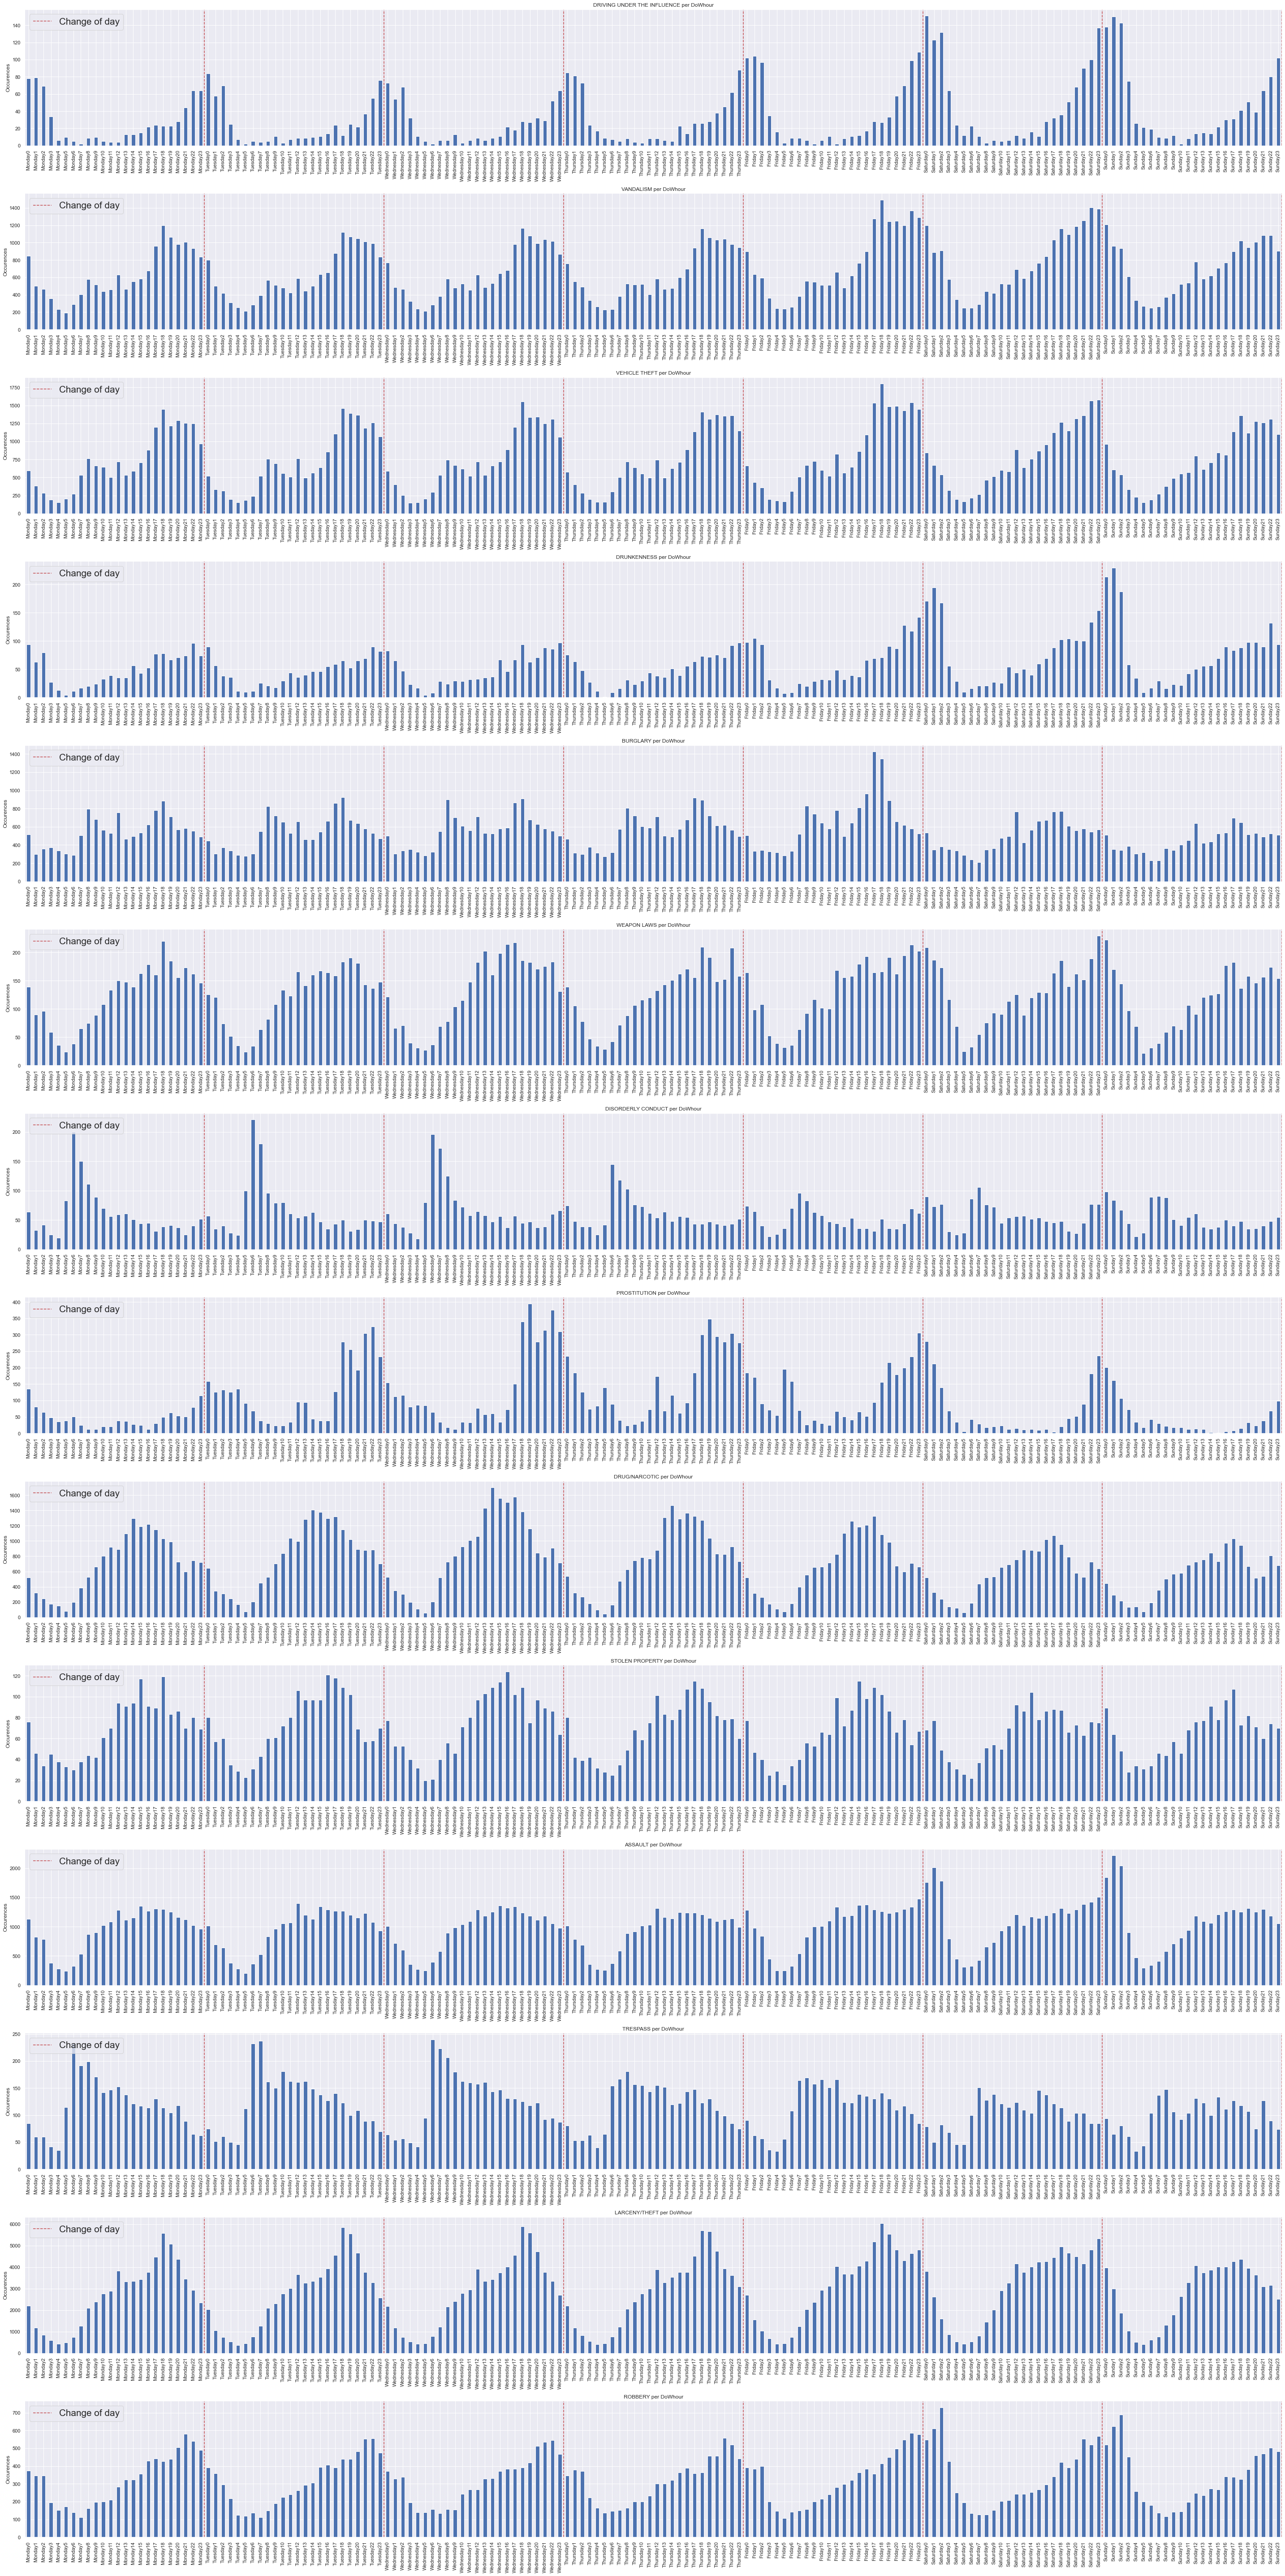

In [4]:
# Use the function for 168-hour (DayOfWeek-hour) plot
temporal = 'DoWhour'

plt.figure(figsize=(40,80))
plt.title("Crime per weekday")
for i, crime in enumerate(focuscrimes):
    plt.subplot(len(focuscrimes), 1,  i+1)
    for v in range(1,8):
        plt.axvline(v*24-0.5, color='r', linestyle='--')
    temporalcrimesplot(crime, temporal=temporal)
    plt.legend(['Change of day'], loc="upper left", fontsize='xx-large')#, color='r', linestyle='--')

Generally speaking, (the incidence reporting of) crime occurs much less during the nighttime. Specifically, "Disorderly Conduct" peaks in the early morning in the beginning of the week and decreases smoothly for each day. "Assault" peaks just after midnight on Friday and Saturday evenings.

#### 1.3) Spatial patterns:
Now let's look into the differences between the different police districts

In [5]:
Pds = D.PdDistrict.dropna().unique()
print(f'Police districts: {Pds}\n')
print('Districts with most (focus) crimes: \n')
print(D.PdDistrict.value_counts())

Police districts: ['RICHMOND' 'NORTHERN' 'SOUTHERN' 'PARK' 'CENTRAL' 'TARAVAL' 'INGLESIDE'
 'MISSION' 'BAYVIEW' 'TENDERLOIN']

Districts with most (focus) crimes: 

SOUTHERN      226805
NORTHERN      172194
MISSION       162971
CENTRAL       139961
BAYVIEW       112054
TENDERLOIN    104950
INGLESIDE     101328
TARAVAL        88132
PARK           67645
RICHMOND       66770
Name: PdDistrict, dtype: int64


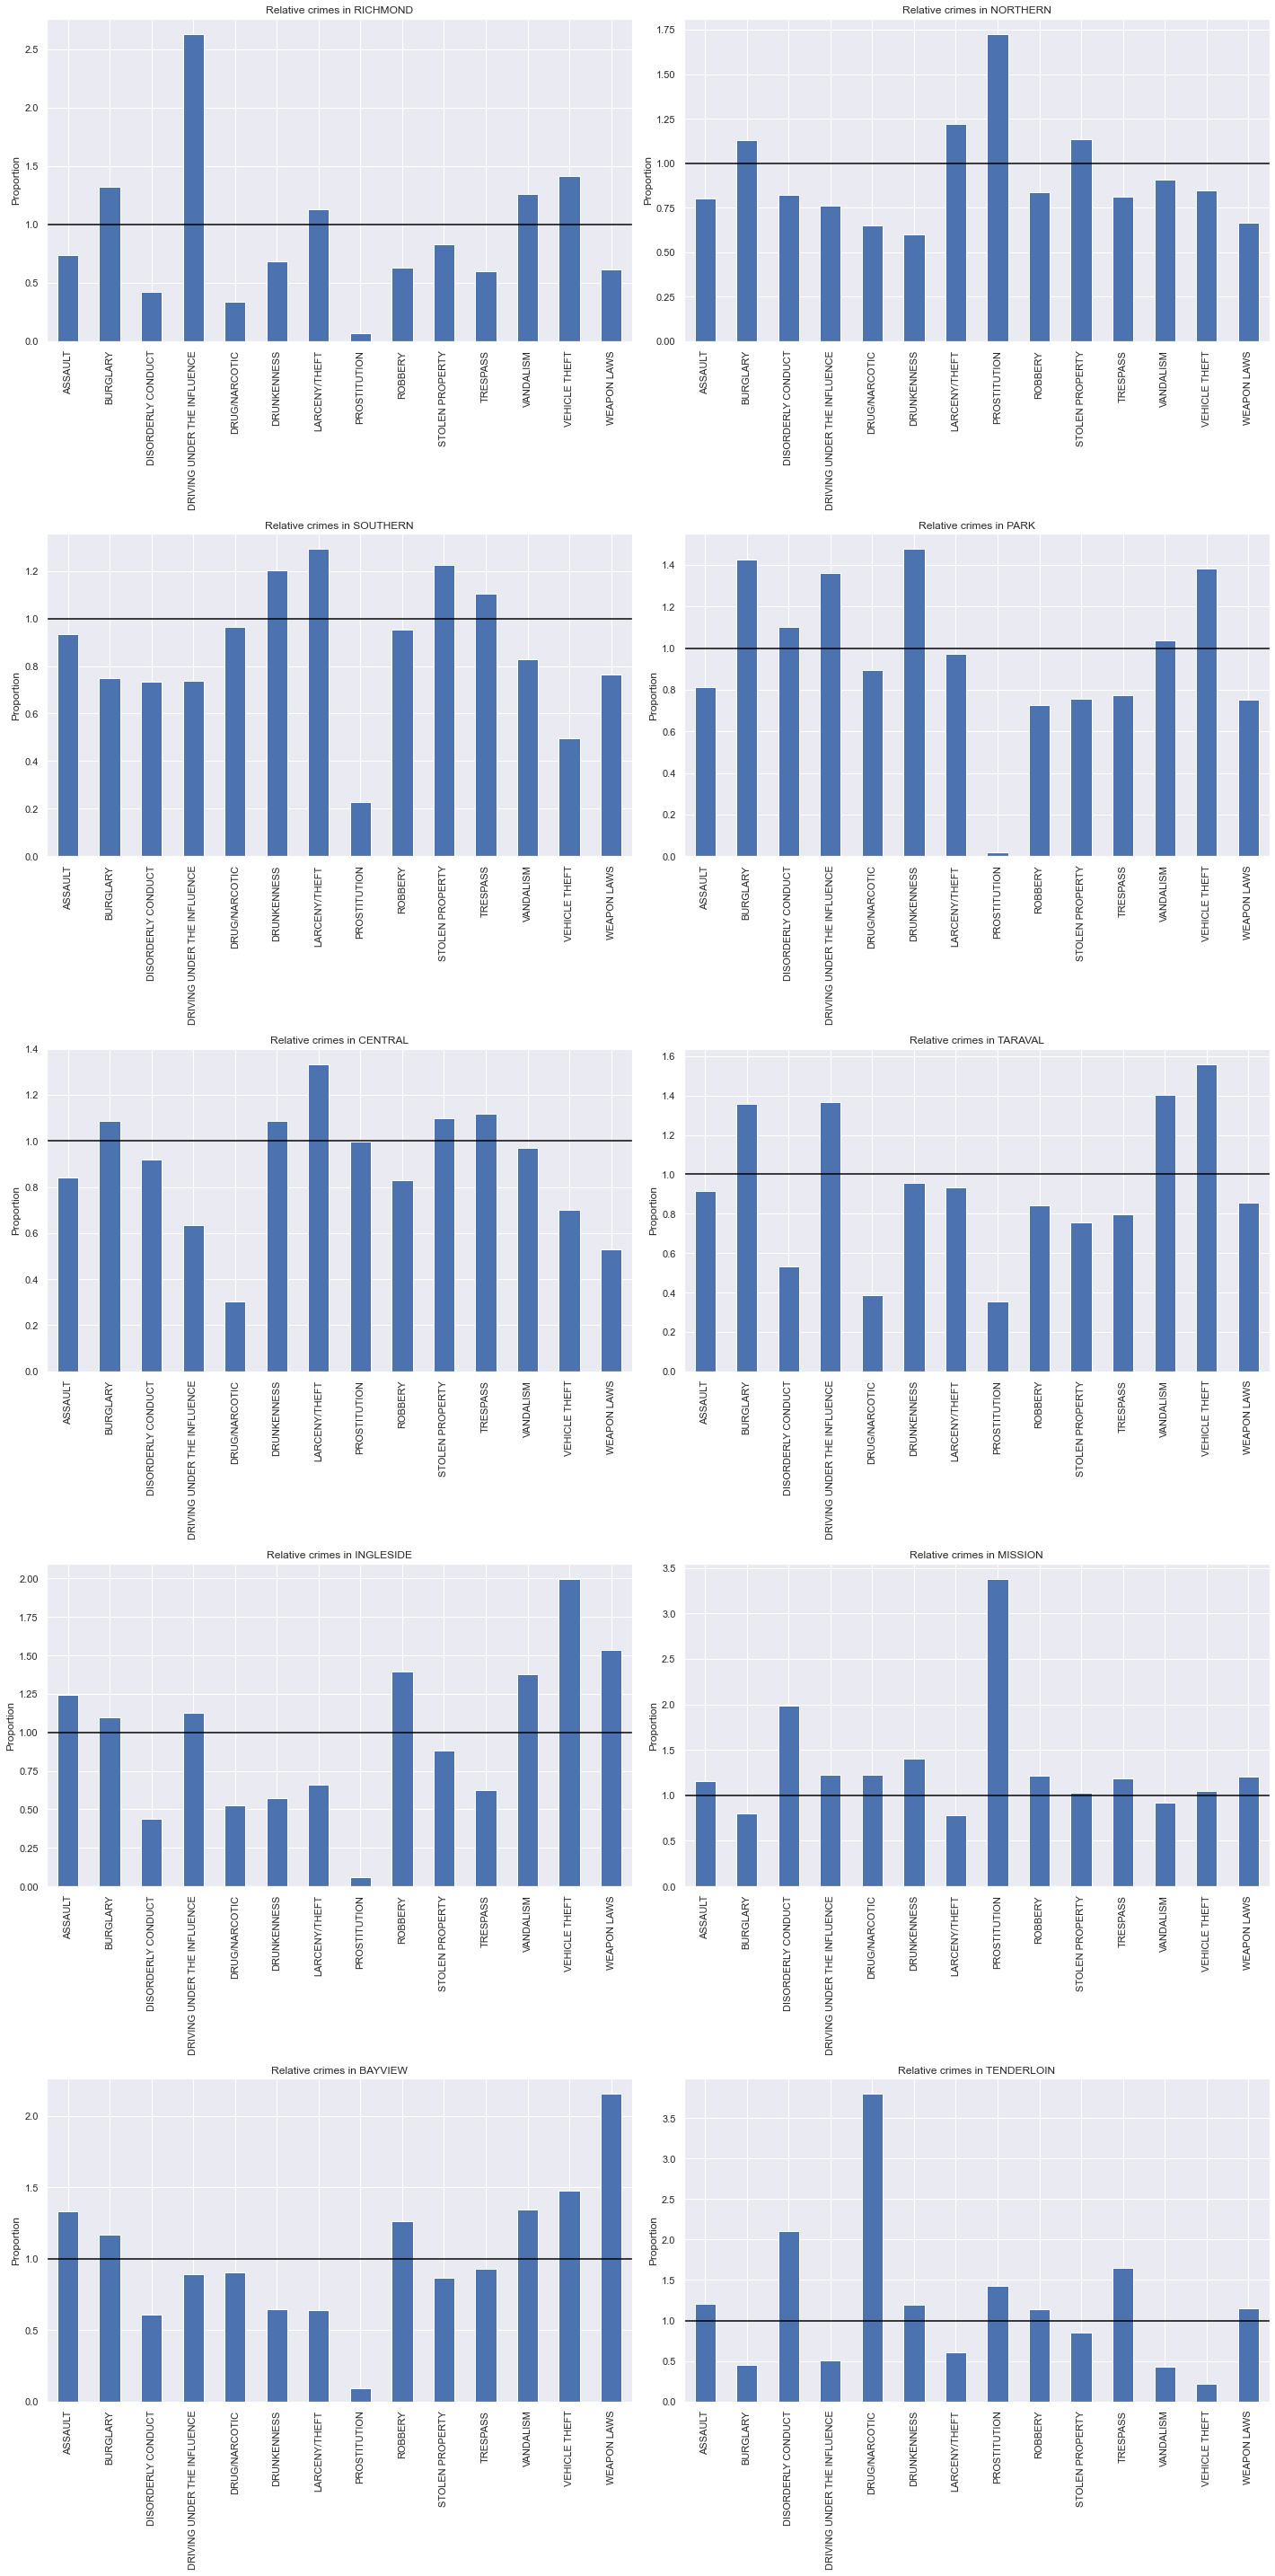

In [6]:
# P(crime)
pcrime = D.Category.value_counts() / n

# P(crime | district) / P(crime)
def relative_crimetype_plot(district):
    val_count = D['Category'][D.PdDistrict == district].value_counts().sort_index()
    rel = val_count / val_count.sum() / pcrime # <--
    rel.plot(kind='bar')
    plt.axhline(y=1,color='black')
    plt.ylabel('Proportion')
    plt.title(f'Relative crimes in {district}');

plt.figure(figsize=(20,40))
for i, district in enumerate(Pds):
    plt.subplot(5, 2,  i+1)
    plt.tight_layout()
    relative_crimetype_plot(district)

Here we see some **very** distinct differences between the police districts. Roughly speaking, the prostitution occurs in Mission (and Northern), Driving under influence occurs in Richmond and drugs are sold in Tenderloin.

Later, in Part 4 we will return to the spatial pattern of prostitution. Can this be seen on a heatmap - and how does it change over time?

## Part 2: Fundamentals of data visualization

In the exercise below, there is a selection of questions from Week 3, Part 1. Please, check it out if you have any doubt on how to solve the exercise.

> *Exercise:* 
>
> * *Questions from the [lecture](https://www.youtube.com/watch?v=yiU56codNlI)*. Sune mentions in the video that it's important to choose the right bin-size in histograms. But how do you do that? Do a Google search to find a criterion you like and explain it. 
> * *Hypothesis testing*. Use [data 1](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_f.csv) and [data 2](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_m.csv) to verify whether there is a statistically significant difference in the average number of steps taken by men and women. 
>     * Is there a statistically significant difference between the two groups? What is the difference between their mean number of steps? Plot two histograms to visualize the step-count distributions, and use the criterion you chose in the previous step to define the right bin-size and comment on your choice.
>     * **Pretend you did not visualize the data yet.** What was the explanation you found for what you observed? Explain the theory, news, papers, further analysis etc. you used to support your conclusions and write down a couple of sentences. Now, think of the actual shape of the data: what do you think the point of this exercise was? 
> * *Scatter plots.* Create a scatter plot with both data samples by using **your own alternative** to `color='#f6756d'` and `color='#10bdc3'`. Explain why you chose this visualization, its pros, and cons.

#### 2.1) Questions from the lecture:
There exists different approaches to picking the right bin-size. Different bin-sizes will uncover different features in the data. Various different criterions have been suggested through time to approximate the optimal bin-size. A relatively simple criterion is Sturge's rule, which is also the first suggested criterion. Many later criterions are based on Sturge's rule. Sturge's rule is defined as $k=\left\lceil\log _{2} n\right\rceil+1$, where $k$ is the optimal number of bins, and $n$ is the number of data points. Sturge's rule is way of basing the bin sizes on the range of the data [(source)](https://en.wikipedia.org/wiki/Histogram#Sturges'_formula).

#### 2.2) Hypothesis testing:

To validate if there is a significant difference between data1 and data2 an independent samples t-test is performed. The two data sets contain information about BMI and number of steps for a males and females respectively.

In [7]:
# Reading the csv files
male = pd.read_csv('data/data9b_m.csv')
female = pd.read_csv('data/data9b_f.csv')

In [8]:
# T-test to test for statistically significant difference
print('P-value for independent samples t-test: ' + str(ttest_ind(male['steps'], female['steps']).pvalue))

P-value for independent samples t-test: 3.498915026461386e-08


On a 95% confidence interval we can thus reject the null hypothesis, and accept the alternative hypothesis that there is a significant difference between the number of steps of males and females.

In [9]:
# Difference between mean number of steps for males and females
print('Difference between mean number of steps: ' + str(np.mean(male['steps']) - np.mean(female['steps'])))

Difference between mean number of steps: 934.7820743791017


The relative difference between the mean number of steps for males and females are approximately 935 steps.
Additionally, a histogram plot of the average number of steps in the two groups are plotted on top of each other. The optimal number of bins is found with Sturge's rule. 

Text(0.5, 1.0, 'Number of Steps')

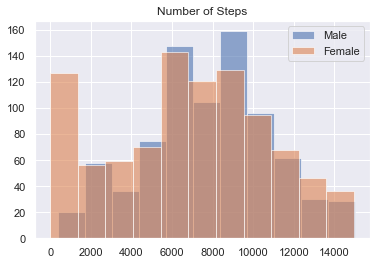

In [10]:
# Using Sturge's rule to calculate the optimal number of bins
n_bins_m = int(np.ceil(math.log2(male.shape[0])) + 1)
n_bins_f = int(np.ceil(math.log2(female.shape[0])) + 1)
ax = plt.hist(male['steps'], bins = n_bins_m, alpha = 0.6);
ax = plt.hist(female['steps'], bins = n_bins_f, alpha = 0.6);
plt.legend(labels = ['Male', 'Female']);
plt.title('Number of Steps')

The histogram shows that there is a heavy left tail in the distibution of number of steps for the female group compared to the male group. This indicates that more females take less steps compared to males.

#### 2.3) Scatter plots

To visualize the data we look at the scatter plot of the two dimensions of each of the two data sets.

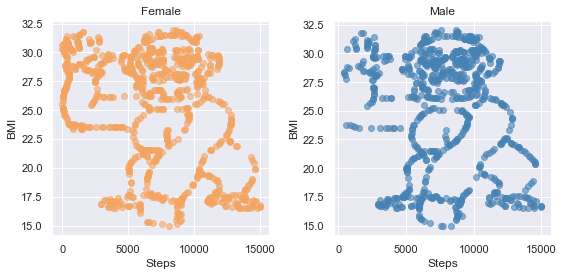

In [11]:
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.scatter(female['steps'], female['bmi'], color='sandybrown', alpha = 0.6)
plt.title('Female')
plt.xlabel('Steps')
plt.ylabel('BMI')
plt.subplot(1,2,2)
plt.scatter(male['steps'], male['bmi'], color='steelblue', alpha = 0.6)
plt.title('Male')
plt.xlabel('Steps')
plt.ylabel('BMI')
plt.tight_layout()

The scatter plots reveal the point of the exercise, namely that having a hypothesis might, distract the analyst from seeing the actual structures in the data (in this example a monkey shape).

## Part 3: Different types of visualization from DAOST

The exercise below, is a selection of questions from Week 3, Part 2 and 3.

> *Exercise:*
>
> * *Questions from DAOST*
>     * Janert, the author of DAOST, is so suspicious of mean, median, and related summary statistics. Explain why one has to be careful when using those - and why visualization of the full data is always better. 
>     * Explain what is a box plot. When are box plots most useful? Are violin plots better or worse than box plots? Why?
> * *Recreating plots from DAOST*. We need some box plots. Here, I'd like you to use the box plots to visualize fluctuations of how many crimes happen per day. We'll use data from the 15 focus crimes defined in Part 1.
>     * For the full time-span of the data, calulate the **number of crimes per day** within each category for the entire duration of the data.
>     * Create a box and whiskers plot showing the mean, median, quantiles, etc. for all 15 crime-types side-by-side. What does this plot reveal that you can't see in the plots from previous weeks?
>     * Now, let's calculate another average for each focus-crime, namely what time of day the crime happens. So this time, the distribution we want to plot is the average time-of-day that a crime takes place. There are many ways to do this, but let me describe one way to do it: 
>        * For datapoint, the only thing you care about is the time-of-day, so discard everything else.
>        * You also have to deal with the fact that time is annoyingly not divided into nice units that go to 100 like many other numbers. (Refer to Week 3 exercise 3.2 for hints.)      
>        * Now, you can create box-plots to create an overview of *when various crimes occur*. Note that these plot have quite a different interpretation than ones we created in the previous exercise. Comment your results. 

#### 3.1) Questions from DAOST:
##### Why one has to be careful with summary statistics
One has to be careful with using simple summary statistics such as mean and median, because they require the distribution to be unimodal (having a single, central peak). This is exactly the point of Ancombe's quartet, which are 4 data sets that have very different distributions, but happen to have very similar summary statistics.

##### Explanation of box plots - When are they most useful and are violin plots better?
A box plot is a graphical representation of a distribution and its potential outliers. A box plot typically consists of a marker for the median, a box that span the interquartile range as a measure of the width of the distribution, a set of whiskers that extends from the box and marks the upper and lower adjacent values and individual representations of outliers. The upper adjacent value for the whisker is defined as the largest value in the data set that is less than twice the inter-quartile range greater than the median. The lower adjacent value is defined similarly. Box plots are generally most useful when comparing multiple distributions. In some cases the violin plot might be a more useful representation of the data than the box plot. This is because the violin plot additionally shows the density trace, which can additionally capture the distributions in the data.

#### 3.2) Recreating plots from DAOST


To recreate plots from DAOST the number of crimes per day is calculated and plotted in 15 boxplots - one for each focus crime.

In [12]:
# Adding column with number of crimes per day
df_focus = df[df.Category.isin(focuscrimes)]
df_focus_box = df_focus.groupby(['Category','Date']).count().reset_index().rename(columns = {'PdId':'No. crimes per day'})

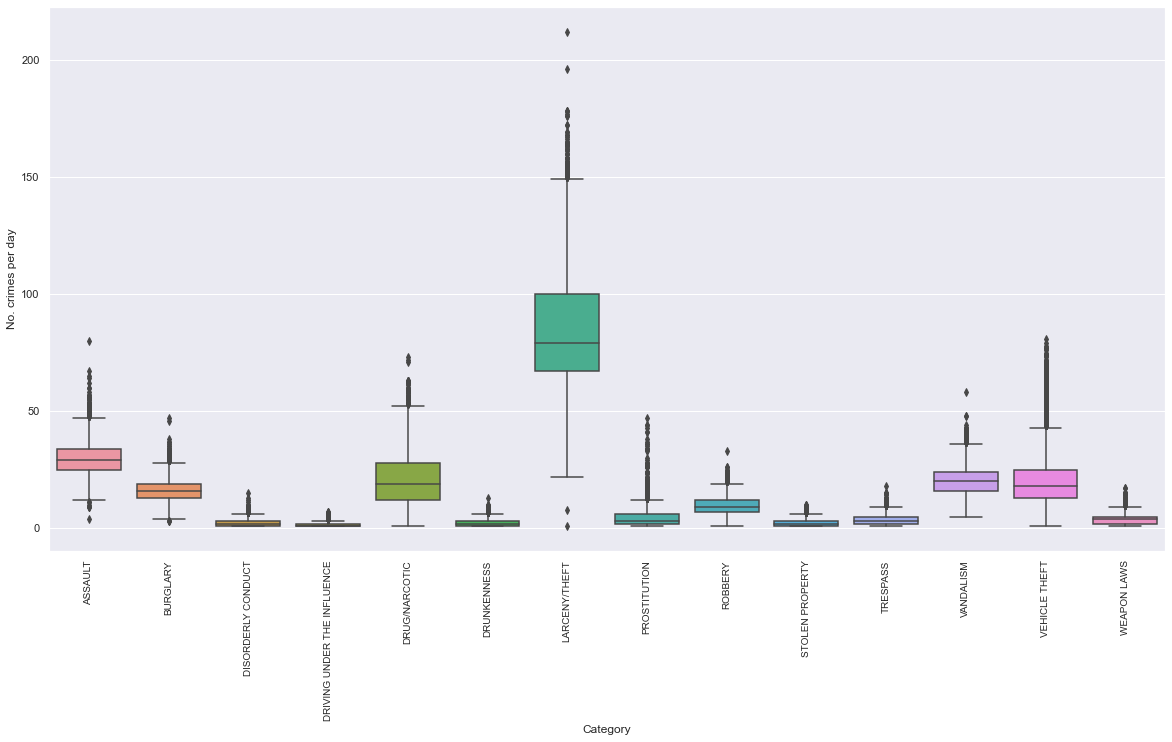

In [13]:
# Box plot of the number of crimes per day for each of the 15 crime types
plt.figure(figsize = [20, 10])
ax = sns.boxplot(x="Category", y="No. crimes per day", data=df_focus_box)
plt.xticks(rotation = 90, fontsize = 10)
plt.show()

From the boxplot we see that especially larceny/theft has a high number of occurances per day and it's distribution is very widespred. Most of the other focus crimes have very narrow distributions indicating that the number of occurances per day is somewhat stable over the time span of the data. The box plot enables us to see outliers clearly compared to plots from previous weeks.

Additionally, we look at time of the day at which the crime is reported. This is visualized in the box plot below showing the time of the day as hours after midnight.

In [14]:
# Creating new column 'Time2' that counts the number of hours after midnight for the incident
df_focus['Hours after midnight'] = df_focus['Time'].str.split(":").apply(lambda x: int(x[0])+ int(x[1])/60)
df_focus['Seconds'] = df_focus['Time'].str.split(":").apply(lambda x: int(x[0]) * 3600 + int(x[1]) * 60)
df_focus_time = df_focus.groupby(['Category','Seconds','Hours after midnight']).count().reset_index().rename(columns = {'PdId':'Time of arrests'})

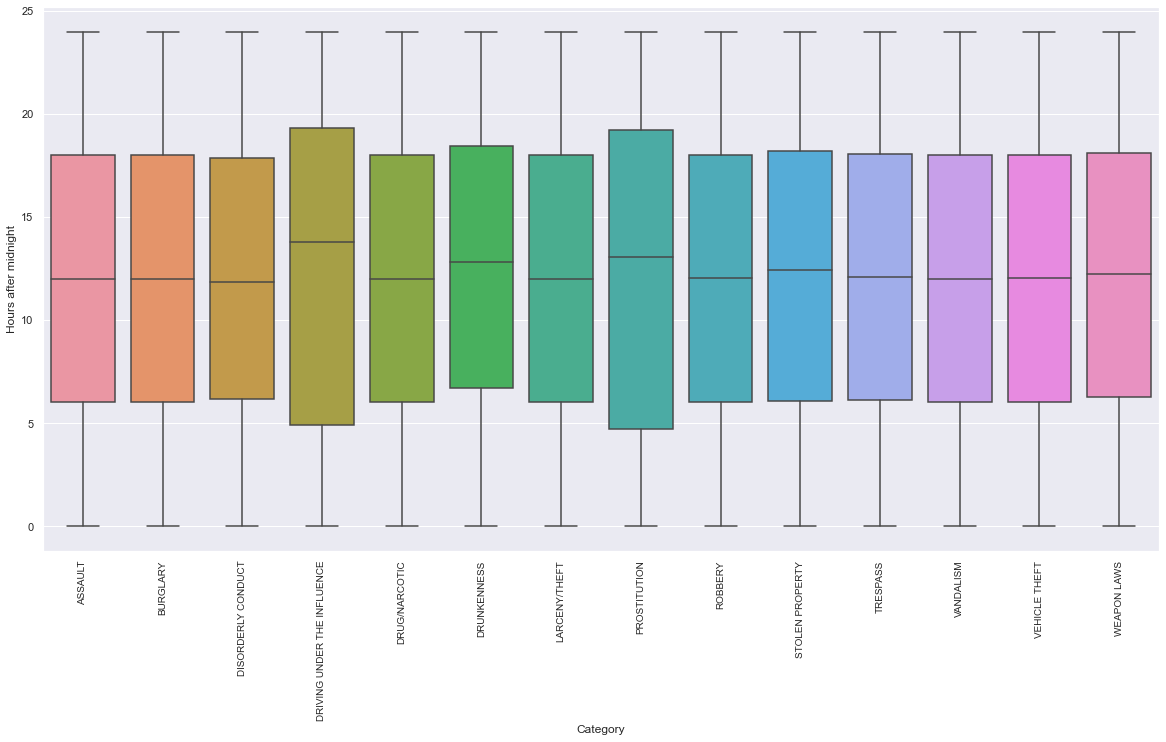

In [15]:
# Box plot overview of when each crime occurs
plt.figure(figsize = [20, 10])
ax = sns.boxplot(x="Category", y="Hours after midnight", data=df_focus_time)
plt.xticks(rotation = 90, fontsize = 10)
plt.show()

The box plot shows that most the focus crimes happen during the day hours i.e. from 06:00 to 18:00. The crimes that appear to be most spread out througout the dat is driving under the influence and prostitution.

## PART 4: Visualizing geo-data

Let's now use the cool Folium functionalites `HeatMap` and `HeatMapWithTime` to create a visualization of the patterns of your favorite crime-type and how they change over time. 

**Note** The exercise below is a mix of exercise 1.2 (**but with the data you choose**) and 1.3 from Week 4.

> *Exercise*: Heatmaps and heatmap movies. you get to make all the choices, but remember to **explain and motivate them**.
> * Start by choosing a crimetype with spatial patterns that change over time. Use your data-exploration from the previous lectures to choose a good one.
> * Create a heatmap by grabbing your crimetype data across all times. Play with parameters to get plots you like and explain why you chose them and what the effect of these parameters are.
> * Now, choose a time-resolution. You could plot daily, weekly, monthly datasets to plot in your movie. Again the goal is to find interesting temporal patterns to display. We want at least 20 frames though. Create the movie using `HeatMapWithTime`.
> * Comment on your results: 
>   - What patterns does your movie reveal?
>   - Motivate/explain the reasoning behind your choice of crimetype and time-resolution (you can also refer to exercises/visualizations that we have done in class to motivate your choice). 

As mentioned in Part 2, we will dive deeper into the spatial patterns of *prostitution*.

In [16]:
# Choose crime of interest. Subset dataframe acordingly.
crime = 'PROSTITUTION'
Dsub = D[D['Category'] == crime]

#### 4.1) Heatmap

Let's plot a heatmap over all occurences of prostitution

In [28]:
# Plot heatmap
scatter = False
radius = 15 # Default: 25
blur = 15 # Default: 15

heat_data = [[row['Y'],row['X']] for index, row in Dsub.iterrows()]
map = folium.Map(location=[37.763795, -122.446747], tiles = 'stamen toner',
                    zoom_start = 12.5) # Uses lat then lon. The bigger the zoom number, the closer in you get

if scatter:
    for latlon in heat_data:
        folium.Circle(latlon).add_to(map)

folium.plugins.HeatMap(heat_data, radius=radius, blur=blur).add_to(map)
map

Here we can really see the distinct differences of prostitution between the police districts as explored in part 1. 'Mission', the district of relative highest prostitution, is the lower buble of the two major heat bubles.

For visualisations we've chosen a radius that reasonably represents that small area around each point - not to large or small. We've chose a blur (a weight so to speak) in accordance such that the differences in spatial patterns become distinct.

#### 4.2) Heatmap over time: Spatial pattern over prostitution over the years
Now let's see how the spatial pattern of prostitution has changed over the years.

In [27]:
# Extract coordinates for each year
years = D['Date'].dt.year.unique()
heat_data_time = [[[row['Y'],row['X'],0.15] for index, row in Dsub[Dsub['Date'].dt.year == year].iterrows()] for year in years]

# HeatMap over time
map = folium.Map(location=[37.763795, -122.446747], tiles = 'stamen toner', zoom_start = 12.5)
HeatMapWithTime(heat_data_time, auto_play=False, max_opacity=1.0).add_to(map)
map


We see the same two major prostitution centres, but they do seem to decrease in the later years, i.e. less prostitution. Additionally we see a change from 2013 and onwards in that the upper centre is dissolved and spreads eastward.

(Note that data from the last year is only from Jan to May.)

## Part 5: Errors in the data. 

We started the course by plotting simple histogram and bar plots that showed a lot of cool patterns. But sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data. 

1. In the temporal activity for `PROSTITUTION` something surprising is going on on Thursday. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/prostitution.png), where I've highlighted the phenomenon I'm talking about.
2. When we investigated the details of how the timestamps are recorded using jitter-plots, we saw that many more crimes were recorded e.g. on the hour, 15 minutes past the hour, and to a lesser in whole increments of 10 minutes. Crimes didn't appear to be recorded as frequently in between those round numbers. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/jitter.png), where I've highlighted the phenomenon I'm talking about.
3. And, during Week 4 we saw that the Hall of Justice seemed to be an unlikely hotspot for sex offences. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/crime_hot_spot.png).

> *Exercise*: Data errors. The data errors we discovered above become difficult to notice when we aggregate data (and when we calculate mean values, as well as statistics more generally). Thus, when we visualize, errors become difficult to notice when binning the data. We explore this process in the exercise below:
>
> * In each of the examples above, describe in your own words how the data-errors, I call attention to above, can bias the binned versions of the data. Also, briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).
> * Find your own example of human noise in the data and visualize it. Comment your results.

#### 5.1) Temporal activity for prostitution:
As there is observed an unusual peak of prostitution cases during a very short time interval on thursdays, the emergence of such pattern leads to the suspision that it is heavily dependent on the sizes of bins chosen for discretising the time points in the dataset. In other words, if we were to use different numbers of bins we will see drastically different distribution patterns of prositution cases on Thursdays, and could have very well missed the peak observed in the image presented by Sune. Therefore we will investigate that further by actually plotting the prostitution cases on Thursdays, varying in bin sizes.

No. bins: 144
No. bins: 48
No. bins: 24


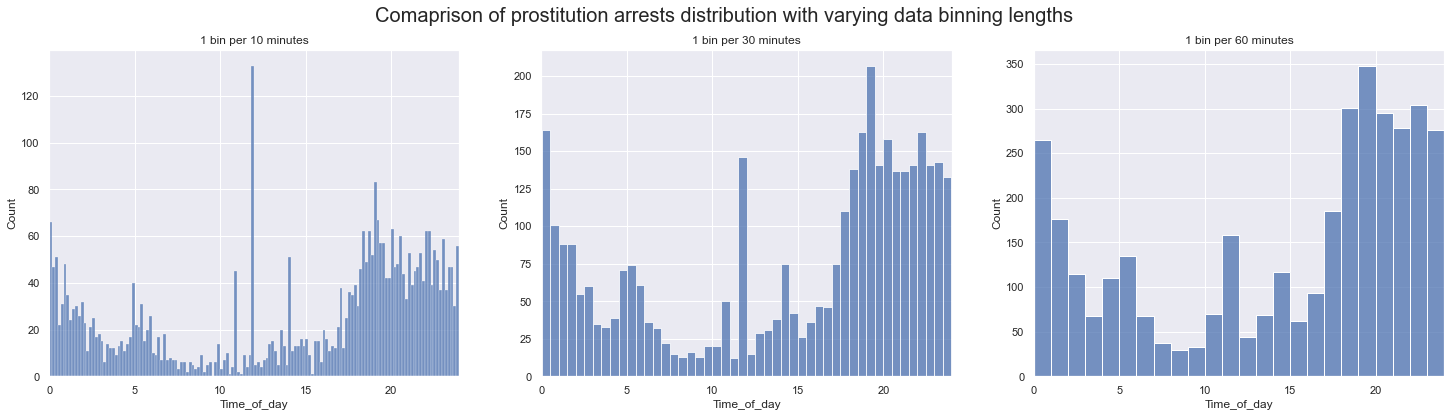

In [19]:
crime = 'PROSTITUTION'
df_pros = df[(df['Category'] == crime) & (df['DayOfWeek'] == 'Thursday')]

# Convert time to be hours post midnight in the format of whole hour.percentage of an hour 
df_pros['Time_of_day'] = df_pros['Time'].str.split(":").apply(lambda x: int(x[0])+ int(x[1])/60)

# Bining
bin_length = np.round([24*6,(24*60)/30,24]) # every 10,30,60 minutes 
fig, axs = plt.subplots(1,3, figsize=(25,6), sharex=True)
for i in range(len(bin_length)):
    print('No. bins:', int(bin_length[i]))
    sns.histplot(data=df_pros, x="Time_of_day", bins=int(bin_length[i]),ax=axs[i]).set_title('1 bin per ' + str(int((24*60)/bin_length[i])) + ' minutes')
plt.xlim(0,24)
plt.suptitle('Comaprison of prostitution arrests distribution with varying data binning lengths',size = 20)
plt.show()

As we can see from the comparison plot above, there is a clear difference between the arrests distribution when we have 1 bin per 10 minutes vs 1 bin per 30 minutes vs 1 bin per hour. The peak count between 10:00 to 15:00 disappears when we consider longer time intervals for binning. Investigating further, we see that interestingly there is a brief deviation of the peak count value from the time interval 10:00 to 13:00 from binning every 17 and 18 minutes, and the peak returns when we bin the data using the 19 minute interval. And from 20 minutes binning range and on the peak gradually disappears. This further comes to show how easily we can form misconceptions of the underlying pattern of the data if with tiny changes in bin numbers. 

In [20]:
df_t = pd.DataFrame()
iv =  pd.Interval(left=10, right=13) # set time interval to check against
for i in range(1,24):
    ranges = np.arange(0,24,i/60)
    df_t[str(i)+' min range'] = pd.cut(df_pros['Time_of_day'], ranges)
    temp = df_t.groupby([str(i)+' min range']).size().sort_values()
    if not iv.overlaps(temp.index[-1]):
        print('Peak arrests count outside of the range 10:00 to 13:00\n',temp.tail(1))

Peak arrests count outside of the range 10:00 to 13:00
 17 min range
(18.983, 19.267]    147
dtype: int64
Peak arrests count outside of the range 10:00 to 13:00
 18 min range
(19.2, 19.5]    143
dtype: int64
Peak arrests count outside of the range 10:00 to 13:00
 20 min range
(18.667, 19.0]    162
dtype: int64
Peak arrests count outside of the range 10:00 to 13:00
 21 min range
(18.9, 19.25]    158
dtype: int64
Peak arrests count outside of the range 10:00 to 13:00
 23 min range
(18.783, 19.167]    160
dtype: int64


Lastly, let's double check the likelihood of the observation on Thursday is a caused by data error. The plot below comparing the distribution for all prostitution cases for each weekday further emphasises the abnormality of the arrests peak count for Thursday, providing strong evidence that it is a data error. 

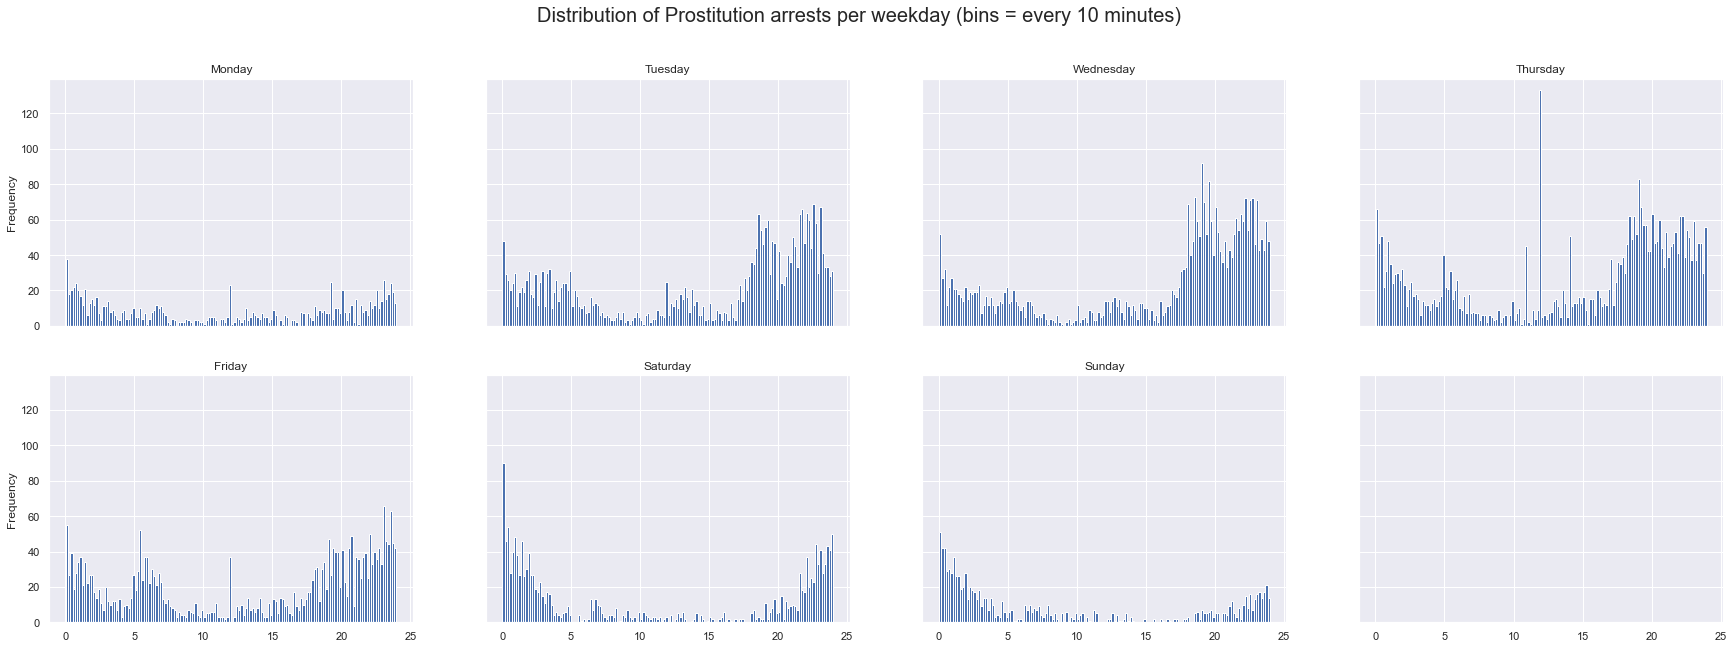

In [21]:
df_pros_all = df[df['Category'] == crime]
df_pros_all['Time_of_day'] = df_pros_all['Time'].str.split(":").apply(lambda x: int(x[0])+ int(x[1])/60)

weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
fig, axes = plt.subplots(2,4, sharex=True, sharey=True,figsize=(30,10))
for i, ax in enumerate(axes.flatten()):
    if i > 6:
        pass
    else:
        df_pros_all[df_pros_all['DayOfWeek'] == weekdays[i]]['Time_of_day'].plot(ax=ax,kind = 'hist',bins=24*6,title = weekdays[i])
plt.suptitle('Distribution of Prostitution arrests per weekday (bins = every 10 minutes)',fontsize=20)
plt.show()

#### 5.2) Time of crime recording:

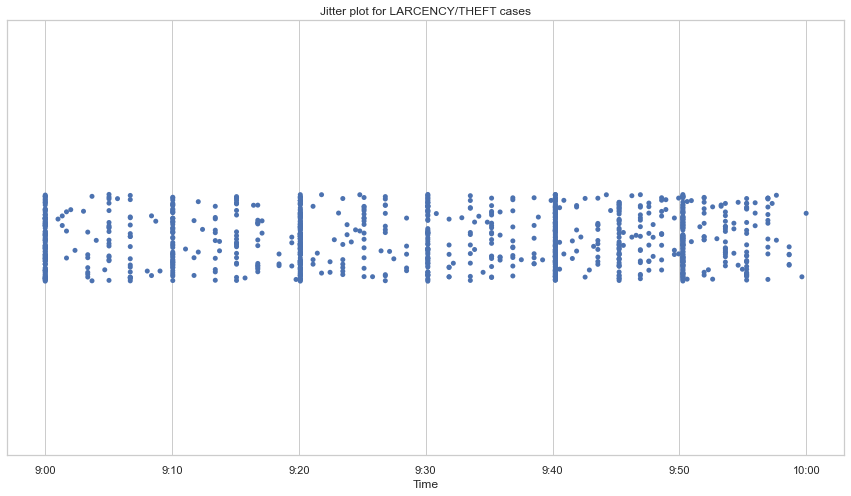

In [22]:
crime = 'LARCENY/THEFT'
df_theft = df[df['Category']==crime]
df_theft['Date'] = pd.to_datetime(df_theft['Date'])
df_theft['Hour'] = pd.DatetimeIndex(df_theft['Time']).hour
mask = (df_theft['Date'] >= '12/01/2017') & (df_theft['Date'] <= '03/01/2018') # define timer interval of datapoins considered
df_jitter = df_theft[mask]
df_jitter_hour = df_jitter[(df_jitter['Hour'] >= 8) & (df_jitter['Hour'] <= 10)] # take hours between 8 to 10 
jitter_time = df_jitter_hour['Time'].str.split(":").apply(lambda x: int(x[0])+ int(x[1])/60)

# plot jitter plots 
plt.figure(figsize=(15,8))
sns.set_style("whitegrid")
ax = sns.stripplot(x=jitter_time,jitter=0.1).set_title('Jitter plot for LARCENCY/THEFT cases')
label_t = ['9:00','9:10','9:20','9:30','9:40','9:50','10:00']
plt.xticks(np.linspace(min(jitter_time),max(jitter_time),7),label_t)
plt.show()

As observed from the jitter plots of when crimes are recorded, the dots seem to be concentrated on increments of 10 min.
time steps, indicating that we need to take this prior into account when analysing the distribution of crimes as it can heavily bias the descriptive statistics. For example, when looking at what time of the day we see the mode of theft/larcency cases, it could be very misleading as we know that police officers tend to record at specific timepoints. Similarly the time point for which the median can also be skewed. Thus the precision of our descriptive statistics decreases due to this data error and we can only make conclusions on frequency of crime occurences within larger time intervals.

#### 5.3) Hotspot for sex offences:
##### Data errors
When visualising where sex offences tend to occur in San Francisco, an unusual spot emerged that seems to have high concentration of sex offences, which lies on 800 Block of Bryant street, where the Hall of Justice is located labelled with red marker on the below plot.

In [23]:
from folium import plugins
import folium
from folium.plugins import HeatMap

crime = 'SEX OFFENSES, NON FORCIBLE'
df_sex = df[df['Category']==crime]

map_heat = folium.Map(location=[37.77919,-122.41914],
                      tiles = "Stamen Toner",
                    zoom_start = 13) 

# Ensure you're handing it floats
df_sex['Y'] = df_sex['Y'].astype(float)
df_sex['X'] = df_sex['X'].astype(float)

# List comprehension to make out list of lists
heat_data = [[row['Y'],row['X']] for index, row in df_sex.iterrows()]

# add marker for hall of justice
folium.Marker([37.77553594756843, -122.40382651403439], popup='Hall of Justice',icon=folium.Icon(color='red', icon='legal', prefix='fa')).add_to(map_heat)
# Display the map
hm = plugins.HeatMap(heat_data,auto_play=True,radius = 12, blur = 5, max_opacity=1)
hm.add_to(map_heat)
map_heat

In [24]:
print('Total number of sex offences in San Fransico from 2003 to 2018:' , len(df_sex))
print('Number of sex offences found on Bryant street:' , len(df_sex[df_sex['Address'].str.contains('BRYANT')]))
df_sex[df_sex['Address'].str.contains('BRYANT')]

Total number of sex offences in San Fransico from 2003 to 2018: 43
Number of sex offences found on Bryant street: 1


,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,...,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
647361,5093696614030,50936966,14030,"SEX OFFENSES, NON FORCIBLE",INCEST,Saturday,08/21/2004,09:00,SOUTHERN,NONE,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,32.0


However, the observation is misleading as there has been only 1 case of sex offence at the location at 9:00, 21-08-2004. And there has only been a total of 43 cases of sex offences in San Francisco in 15 years. Therefore, focusing solely on the heatmap of sex offence cases concentration can led people to believe that the hall of justice is a dangerous place with the premise that there are a large number of cases in the city in general, whereas it only happened once or it could be a mistake in crime register.

##### Examples of human noise in the data

The first row of the dataset has recorded a larcency/theft case on Sunday 09/28/2003 at the Southern district, 1st st / Brannan ST with the GPS coordinate of (90,-120.5) which is obviously incorrect as it locates somewhere in the ocean of the arctic region as shown below. The correct coordinate for the address should be around (37.785, -122.388). 

In [33]:
map_SF = folium.Map(location=[90,-120.5],
                        zoom_start = 1)
folium.Marker([90,-120.5], popup='Wrong coordinate',icon=folium.Icon(color='red', icon='exclamation', prefix='fa')).add_to(map_SF)
map_SF

Looking further into more potential mislabelling of GPS locations, we use the knowledge that coordinates for locations in San Francisco are approximately [37.0, 38.0] for latitude and [-122, -123] for longitude with minimal deviation down to the hundredths decimal place. This means that anything outside of these ranges will be likely due to human noise.

In [26]:
df_gps_error = df[(df['Y'] < 37) | (df['Y'] > 38) | (df['X'] > -122) | (df['Y'] < -123)]
df_gps_error['Date'] =pd.to_datetime(df_gps_error.Date)
df_gps_error = df_gps_error.sort_values(by='Date').reset_index()
print('There are', len(df_gps_error),'mislabelled locations')
print('The mislablled coordinates are:', set(df_gps_error.X), set(df_gps_error.Y))
print('Date range of the mislabelled crime cases:', df_gps_error['Date'][0], 'to', df_gps_error['Date'][140])
print('Types of crimes mislabelled', set(df_gps_error.Category))
print('Districts of crimes mislabelled', set(df_gps_error.PdDistrict))


There are 141 mislabelled locations
The mislablled coordinates are: {-120.5} {90.0}
Date range of the mislabelled crime cases: 2003-02-05 00:00:00 to 2005-12-30 00:00:00
Types of crimes mislabelled {'VEHICLE THEFT', 'SECONDARY CODES', 'DISORDERLY CONDUCT', 'PROSTITUTION', 'SUSPICIOUS OCC', 'TRESPASS', 'LARCENY/THEFT', 'OTHER OFFENSES', 'SEX OFFENSES, FORCIBLE', 'NON-CRIMINAL', 'ASSAULT', 'ROBBERY', 'VANDALISM', 'BURGLARY', 'KIDNAPPING', 'STOLEN PROPERTY', 'DRUG/NARCOTIC', 'WARRANTS', 'WEAPON LAWS', 'FRAUD'}
Districts of crimes mislabelled {'SOUTHERN', 'TARAVAL', 'PARK', 'TENDERLOIN', 'RICHMOND', 'BAYVIEW', 'INGLESIDE', 'MISSION', 'CENTRAL', 'NORTHERN'}


As shown above there are 141 "mislocated" crime between cases with the same incorrected X and Y values, namely [-120.5, 90]. And these mislabellings occurred between 2003 to 2005 for wide range of different crimes and districts. We could suspect that maybe the coordinate system on some of the police equipments or cars malfunctioned during the period which resulted in the error in crime location records.